In [1]:
from keras import optimizers, regularizers
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers.recurrent import LSTM
from keras.utils import np_utils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from time import time
from IPython.display import FileLink

from sklearn.metrics import confusion_matrix

from keras.preprocessing import image

from keras.datasets import mnist

Using TensorFlow backend.


# Funções

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label verdadeira',
           xlabel='Label predita')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [3]:
def graficos(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=[15,5])
    plt.subplot(121)
    plt.plot(epochs, acc, 'g.-', label='Acurácia do Conjunto de Treino')
    plt.plot(epochs, val_acc, 'r.-', label='Acurácia do Conjunto de  Validação')
    plt.title('Treino e Validação da Acurácia Modelo Simples Menor')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.plot(epochs, loss, 'g.-', label='Log loss do Conjunto de Treino')
    plt.plot(epochs, val_loss, 'r.-', label='Log loss do Conjunto de Validação')
    plt.title('Treino e Validação log loss Modelo Simples Menor')
    plt.xlabel('Épocas')
    plt.ylabel('Log Loss')
    plt.legend(loc='best')
    plt.show()

In [5]:
def matrixConfusaDigits(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 
    
    target_names = ["0","1","2","3","4","5","6","7","8","9"]
    plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names, title='Matriz de Confusão');

In [6]:
def savePesos(modelManualMenor):

    arqInfoRede = modelManualMenor.get_config()

    ######################################### 
    ######## CAMADA CONVOLUCIONAL ###########
    #########################################
    iniciar_conv_h = open('iniciarConv.h', 'w')

    # INFORMAÇÕES ÚTEIS
    iniciar_conv_h.write("#define LinhasImg "+ str(arqInfoRede['layers'][0]['config']['batch_input_shape'][1])+"\n")
    iniciar_conv_h.write("#define ColunasImg "+ str(arqInfoRede['layers'][0]['config']['batch_input_shape'][2])+"\n")
    iniciar_conv_h.write("#define QntFiltros "+ str(arqInfoRede['layers'][0]['config']['filters'])+"\n")

    # BIAS
    name = "conv_bias"
    iniciar_conv_h.write("float "+name+" ["+str(modelManualMenor.weights[1].shape.dims[0].value)+"] = {")
    for j in range(modelManualMenor.weights[1].shape.dims[0].value - 1):
        iniciar_conv_h.write(str(modelManualMenor.weights[1].numpy()[j])+",")
    iniciar_conv_h.write(str(modelManualMenor.weights[1].numpy()[j+1])+"};\n")

    # KERNEL
    array4D = modelManualMenor.weights[0]
    for camada in range(array4D.shape[2]):
        iniciar_conv_h.write("Mat kernelConv ["+str(array4D.shape[3])+"] = {")        
        for filtro in range(array4D.shape[3]):
            iniciar_conv_h.write("(Mat_<float>("+str(array4D.shape[0])+","+str(array4D.shape[1])+") <<")
            for i in range(array4D.shape[0]):
                for j in range(array4D.shape[1]-1):
                    iniciar_conv_h.write(str(array4D[i][j][camada][filtro].numpy())+",")
                if i+1 == int(array4D.shape[0]) and filtro == (int(array4D.shape[3])-1):
                    iniciar_conv_h.write(str(array4D[i][j+1][camada][filtro].numpy())+")};\n")
                elif i+1 == int(array4D.shape[0]):
                    iniciar_conv_h.write(str(array4D[i][j+1][camada][filtro].numpy())+"),")
                else:
                    iniciar_conv_h.write(str(array4D[i][j+1][camada][filtro].numpy())+",")


    iniciar_conv_h.close()
    ######################################### 
    ########### CAMADA MAXPOOL ##############
    #########################################
    iniciar_pool_h = open('iniciarPool.h', 'w')

    # COLOCAR DEPOIS OS DOIS TAMANHOS!!!!!
    iniciar_pool_h.write("#define tamMaxPool "+ str(arqInfoRede['layers'][1]['config']['pool_size'][0])+"\n")


    iniciar_pool_h.close()
    ######################################### 
    ############ CAMADA DENSE ###############
    #########################################
    iniciar_dense_h = open('iniciarDense.h', 'w')

    # STRUCT NEURONIO 
    iniciar_dense_h.write("typedef struct Neuronio{\n    vector <float> pesos;\n    float bias;\n} neuronio;\n\n")

    # VETOR FUNÇÕES DE ATIVAÇÃO
    iniciar_dense_h.write("vector <string> camadasRede = {")

    for i in range(3, len(arqInfoRede['layers'])-1): #só as camadas densas
        iniciar_dense_h.write("\""+arqInfoRede['layers'][i]['config']['activation']+"\",")
    iniciar_dense_h.write("\""+arqInfoRede['layers'][len(arqInfoRede['layers'])-1]['config']['activation']+"\"};\n")

    # VETOR QUANTIDADE DE NEURONIOS
    qntNeurorio = 0
    iniciar_dense_h.write("vector <int> qntNeuronioCamada = {")

    for i in range(3, len(arqInfoRede['layers'])-1): #só as camadas densas
        qntNeurorio += arqInfoRede['layers'][i]['config']['units']
        iniciar_dense_h.write(str(arqInfoRede['layers'][i]['config']['units'])+", ")
    qntNeurorio += arqInfoRede['layers'][len(arqInfoRede['layers'])-1]['config']['units']
    iniciar_dense_h.write(str(arqInfoRede['layers'][len(arqInfoRede['layers'])-1]['config']['units'])+"};\n\n")

    # QUANTIDADE TOTAL DE NEURONIOS
    iniciar_dense_h.write("#define qntTotalNeuronios " + str(qntNeurorio) + "\n")

    # INICIALIZAÇÃO DOS NEURONIOS
    iniciar_dense_h.write("neuronio vet_Neuronios [qntTotalNeuronios] = {")
    # {{},{{vet},bias}}
    for i in range(2,len(modelManualMenor.weights), 2):
        bias = modelManualMenor.weights[i+1].numpy()
        valores = modelManualMenor.weights[i].numpy()
        qntColunas = int(modelManualMenor.weights[i].shape.dims[1].value)
        if (i == (len(modelManualMenor.weights)-2)): #ultima camada
            for col in range(qntColunas-1): #percorrer as colunas
                iniciar_dense_h.write("{{") #vetor
                for lin in range(int(modelManualMenor.weights[i].shape.dims[0].value)-1):
                    iniciar_dense_h.write(str(valores[lin][col])+",")
                iniciar_dense_h.write(str(valores[lin+1][col])+"},"+str(bias[col])+"},") #vetor e tupla

            iniciar_dense_h.write("{{") #vetor
            for lin in range(int(modelManualMenor.weights[i].shape.dims[0].value)-1):
                iniciar_dense_h.write(str(valores[lin][qntColunas-1])+",")
            iniciar_dense_h.write(str(valores[lin+1][qntColunas-1])+"},"+str(bias[qntColunas-1])+"}};\n") #vetor e tupla e vetorzao
        else:
            for col in range(qntColunas): #percorrer as colunas
                iniciar_dense_h.write("{{") #vetor
                for lin in range(int(modelManualMenor.weights[i].shape.dims[0].value)-1):
                    iniciar_dense_h.write(str(valores[lin][col])+",")
                iniciar_dense_h.write(str(valores[lin+1][col])+"},"+str(bias[col])+"},") #vetor e tupla
    
    iniciar_dense_h.close()


# Dataset Mnist

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

In [9]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [10]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [15]:
X_trainMenor = X_train[:10000]
y_trainMenor = y_train[:10000]

X_testMenor = X_test[:8000]
y_testMenor = y_test[:8000]

In [16]:
print(X_trainMenor.shape)
print(y_trainMenor.shape)
print(X_testMenor.shape)
print(y_testMenor.shape)

(10000, 28, 28, 1)
(10000, 10)
(8000, 28, 28, 1)
(8000, 10)


In [17]:
RESOLUTION = 28
BATCH_SIZE = 10

N_TRAIN = X_trainMenor.shape[0]
N_VAL = X_testMenor.shape[0]

print(N_TRAIN)
print(N_VAL)

10000
8000


In [12]:
modelDigits = Sequential()

modelDigits.add(Conv2D(4, (3,3), input_shape=(28, 28, 1), activation='relu'))
modelDigits.add(MaxPooling2D(pool_size = (2,2)))
modelDigits.add(Flatten())

modelDigits.add(Dense(10, activation='relu'))
modelDigits.add(Dense(8, activation='relu'))
modelDigits.add(Dense(6, activation='relu'))
modelDigits.add(Dense(10, activation='softmax'))

modelDigits.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc'])

In [18]:
history = modelDigits.fit(X_trainMenor, y_trainMenor,
          steps_per_epoch=(N_TRAIN // BATCH_SIZE),
          #batch_size=128, 
          epochs=10,
          validation_data=(X_testMenor, y_testMenor),
          validation_steps=(N_VAL // BATCH_SIZE)
          )

Train on 10000 samples, validate on 8000 samples
Epoch 1/10
1000/1000 [==============================] - 42s 42ms/step - loss: 1.3605 - acc: 0.4976 - val_loss: 0.0016 - val_acc: 421.6000
Epoch 2/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.8070 - acc: 0.7411 - val_loss: 8.8666e-04 - val_acc: 617.9000
Epoch 3/10
1000/1000 [==============================] - 59s 59ms/step - loss: 0.4039 - acc: 0.8782 - val_loss: 6.5905e-04 - val_acc: 679.6000
Epoch 4/10
1000/1000 [==============================] - 59s 59ms/step - loss: 0.2897 - acc: 0.9145 - val_loss: 6.3173e-04 - val_acc: 690.7000
Epoch 5/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.2179 - acc: 0.9403 - val_loss: 6.3852e-04 - val_acc: 703.1000
Epoch 6/10
1000/1000 [==============================] - 59s 59ms/step - loss: 0.1584 - acc: 0.9591 - val_loss: 6.8028e-04 - val_acc: 707.1000
Epoch 7/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1155 - acc: 0.9727 - va

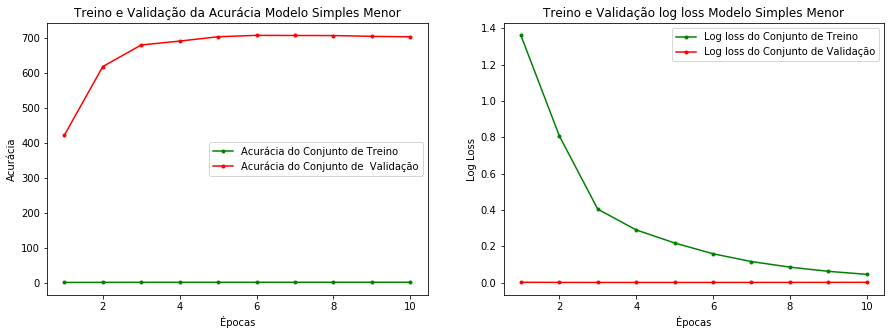

10000/10000 [==============================] - 1s 92us/step
[0.9414586520759389, 0.8884000182151794]


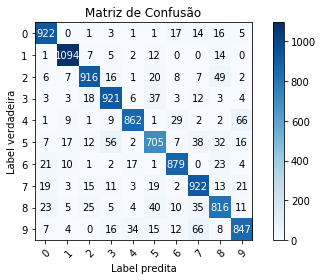

In [19]:
graficos(history)
matrixConfusaDigits(modelDigits, X_test, y_test)
print(modelDigits.evaluate(X_test, y_test))

In [20]:
modelDigits.metrics_names

['loss', 'acc']

In [21]:
img0 = cv2.imread("../input/digitstest/imageTest0.jpg", 0)
img1 = cv2.imread("../input/digitstest/imageTest1.jpg", 0)
img2 = cv2.imread("../input/digitstest/imageTest2.jpg", 0)
img7 = cv2.imread("../input/digitstest/imageTest7.jpg", 0)

In [22]:
img0 = img0/255
img1 = img1/255
img2 = img2/255
img7 = img7/255

In [23]:
img0 = np.reshape(img0,[1,28,28,1])
img1 = np.reshape(img1,[1,28,28,1])
img2 = np.reshape(img2,[1,28,28,1])
img7 = np.reshape(img7,[1,28,28,1])

In [24]:
print(modelDigits.predict(img0))
print(modelDigits.predict(img1))
print(modelDigits.predict(img2))
print(modelDigits.predict(img7))

[[9.9758196e-01 1.0275129e-11 2.8200890e-13 1.4491323e-16 5.3583797e-17
  3.7580075e-10 1.7803187e-09 9.1398615e-05 2.3233672e-03 3.1898667e-06]]
[[1.4914139e-19 9.9948490e-01 2.5758642e-09 1.1131055e-09 7.7069071e-09
  4.6252483e-04 4.5645553e-05 6.7899018e-13 3.0101955e-07 6.6518442e-06]]
[[1.8970161e-08 1.6856330e-02 9.6181238e-01 3.7527999e-03 4.6998710e-05
  1.6803419e-02 2.5299931e-04 6.7623238e-05 3.9195913e-04 1.5573069e-05]]
[[8.0609119e-09 2.1877674e-19 3.2256722e-34 2.8514452e-22 9.4275855e-26
  3.3844394e-10 6.5858481e-22 9.9974149e-01 1.8092825e-08 2.5844760e-04]]


In [25]:
print(np.argmax(modelDigits.predict(img0), axis=1)[:25])
print(np.argmax(modelDigits.predict(img1), axis=1)[:25])
print(np.argmax(modelDigits.predict(img2), axis=1)[:25])
print(np.argmax(modelDigits.predict(img7), axis=1)[:25])

[0]
[1]
[2]
[7]


## Imprimindo valores das camadas para verificar se o código em c++ estava gerando os valores corretos

In [ ]:
modelDigits.predict_proba(img0)

In [ ]:
modelDigits.summary()

In [ ]:
from keras.models import Model

In [ ]:
layer_name1 = 'conv2d_1'
layer_name2 = 'max_pooling2d_1'
layer_name3 = 'flatten_1'

intermediate_layer_model1 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name1).output)
intermediate_layer_model2 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name2).output)
intermediate_layer_model3 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name3).output)
print("######### CONV ############\n")
print(intermediate_layer_model1.predict(img0))
print("\n######### MAX POOL ############\n")
print(intermediate_layer_model2.predict(img0))
print("\n######### FLATTEN ############\n")
print(intermediate_layer_model3.predict(img0))


In [ ]:
type(intermediate_layer_model3.predict(img0))

In [ ]:
vet = intermediate_layer_model3.predict(img0)
type(vet)

In [ ]:
vet[0][3]

In [ ]:
layer_name1 = 'dense_1'
layer_name2 = 'dense_2'
layer_name3 = 'dense_3'
layer_name4 = 'dense_4'

intermediate_layer_model1 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name1).output)
intermediate_layer_model2 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name2).output)
intermediate_layer_model3 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name3).output)
intermediate_layer_model4 = Model(inputs=modelDigits.input,
                                 outputs=modelDigits.get_layer(layer_name4).output)

print("############# CAMADA 0 ###############")
print(intermediate_layer_model1.predict(img0))
print("############# CAMADA 1 ###############")
print(intermediate_layer_model2.predict(img0))
print("############# CAMADA 2 ###############")
print(intermediate_layer_model3.predict(img0))
print("############# CAMADA 3 ###############")
print(intermediate_layer_model4.predict(img0))

In [ ]:
from keras import backend as K

# Salvando os pesos do modelo

In [26]:
savePesos(modelDigits)

In [27]:
FileLink("iniciarConv.h")
# FileLink("iniciarPool.h")
# FileLink("iniciarDense.h")

/kaggle/working/iniciarConv.h

In [28]:
FileLink("iniciarDense.h")

/kaggle/working/iniciarDense.h

In [29]:
modelDigits.save_weights("pesosModelDigits10EpocasBOMRESULTADO.h5")
FileLink("pesosModelDigits10EpocasBOMRESULTADO.h5")

/kaggle/working/pesosModelDigits10EpocasBOMRESULTADO.h5